# Chapter 1 - Softmax from First Principles

## Language barriers between humans and autonomous systems

If our goal is to help humans and autnomous systems communicate, we need to speak in a common language. Just as humans have verbal and written languages to communicate ideas, so have we developed mathematical languages to communicate information. Probability is one of those languages and, thankfully for us, autonomous systems are pretty good at describing probabilities, even if humans aren't. This document shows one technique for translating a human language (English) into a language known by autonomous systems (probability).

Our translator is something called the **SoftMax classifier**, which is one type of probability distribution that takes discrete labels and translates them to probabilities. We'll show you the details on how to create a softmax model, but let's get to the punchline first: we can decompose elements of human language to represent a partitioning of arbitrary state spaces. 

Say, for instance, we'd like to specify the location of an object in two dimensional cartesian coordinates. Our state space is all combinations of *x* and *y*, and we'd like to translate human language into some probability that our target is at a given combination of *x* and *y*. One common tactic humans use to communicate position is range (near, far, next to, etc.) and bearing (North, South, SouthEast, etc.). This already completely partitions our *xy* space: if something is north, it's not south; if it's east, it's not west; and so on.

A softmax model that translates range and bearing into probability in a state space is shown below:

<img src="https://raw.githubusercontent.com/COHRINT/cops_and_robots/master/notebooks/softmax/img/softmax_range_bearing.png" alt="Softmax range and bearing" width=500px>

Assuming that *next to* doesn't require a range, we see seventeen different word combinations we can use to describe something's position: two ranges (*nearby* and *far*) for each cardinal and intercardinal direction (eight total), and then one extra label for *next to*. This completely partitions our entire state space $\mathbb{R}^2$.

This range and bearing language is, by its nature, inexact. If I say, "That boat is far north.", you don't have a deterministic notion of exactly where the boat is -- but you have a good sense of where it is, and where it is not. We can represent that sense probabilistically, such that the probability of a target existing at a location described by a range and bearing label is nonzero over the entire state space, but that probability is very small if not in the area most associated with that label.

What do we get from this probabilistic interpretation of the state space? We get a two-way translation between humans and autonomous systems to describe anything we'd like. If our state space is one-dimensional relative velocity (i.e. the derivative of range without bearing), I can say, "She's moving really fast!", to give the autonomous system a probability distribution over my target's velocity with an expected value of, say, 4 m/s. Alternatively, if my autnomous system knows my target's moving at 0.04352 m/s, it can tell me, "Your target is moving slowly." Our labeled partitioning of the state space (that is, our classifier) is the mechanism that translates for us.

## Softmax model construction
The [SoftMax function](http://en.wikipedia.org/wiki/Softmax_function) goes by many names: normalized exponential, multinomial logistic function, log-linear model, sigmoidal function. We use the SoftMax function to develop a classification model for our state space:

$$
\begin{equation}
P(L=i \vert \mathbf{x}) = \frac{e^{\mathbf{w}_i^T \mathbf{x} + b_i}}{\sum_{k=1}^M e^{\mathbf{w}_k^T\mathbf{x} + b_k}}
\end{equation}
$$

Where $L = i$ is our random variable of class labels instantiated as class $i$, $\mathbf{x}$ is our state vector, $\mathbf{w}_i$ is a vector of parameters (or weights) associated with our class $i$, $b_i$ is a bias term for class $i$, and $M$ is the total number of classes.

The terms *label* and *class* require some distinction: a label is a set of words associated with a class (i.e. *far northwest*) whereas a class is a probability distribution over the entire state space. They are sometimes used interchangeably, and the specific meaning should be clear from context.

Several key factors come out of the SoftMax equation:
- The probabilities of all classes for any given point $\mathbf{x}$ sum to 1.
- The probability any single class for any given point $\mathbf{x}$ is bounded by 0 and 1.
- The space can be partitioned into an arbitrary number of classes (with some restrictions about those classes - more on this later).
- The probability of one class for a given point $\mathbf{x}$ is determined by that class' weighted exponential sum of the state vector *relative* to the weighted exponential sums of *all* classes.
- Since the probability of a class is conditioned on $\mathbf{x}$, we can apply estimators such as [Maximum Likelihood](http://en.wikipedia.org/wiki/Maximum_likelihood) to learn SoftMax models.
- $P(L=i \vert \mathbf{x})$ is convex in $\mathbf{w_i}$ for any $\mathbf{x}$.

Let's try to get some intuition about this setup. For a two-dimensional case with state $\mathbf{x} = \begin{bmatrix}x & y\end{bmatrix}^T$, each class $i$ has weights $\mathbf{w}_i = \begin{bmatrix}w_{i,x} & w_{i,y}\end{bmatrix}^T$. Along with the constant bias term $b_i$, we have  one weighted linear function of $x$ and one weighted linear function of $y$. Each class's probability is normalized with respect to the sum of all other classes, so the weights can be seen as a relative scaling of one class over another in any given state. The bias weight increases a class's probability in all cases, the $x$ weight increases the class's probability for greater values of $x$ (and positive weights), and the $y$ weight, naturally, increases the class's probability for greater values of $y$ (and positive weights).

We can get fancy with our state space, having states of the form $\mathbf{x} = \begin{bmatrix}x & y & x^2 & y^2 & 2xy\end{bmatrix}^T$, but we'll build up to states like that. Let's look at some simpler concepts first.

## Class boundaries

For any two classes, we can take the ratio of their probabilities to determine the **odds** of one class instead of the other:

$$
L(i,j) =\frac{P(L=i \vert \mathbf{x})}{P(L=j \vert \mathbf{x})} = 
\frac{\frac{e^{\mathbf{w}_i^T \mathbf{x} + b_i}}{\sum_{k=i}^M e^{\mathbf{w}_k^T\mathbf{x} + b_k}}}{\frac{e^{\mathbf{w}_j^T \mathbf{x} + b_{j}}}{\sum_{k=i}^M e^{\mathbf{w}_k^T\mathbf{x} + b_k}}} = \frac{e^{\mathbf{w}_i^T \mathbf{x} + b_i}}{e^{\mathbf{w}_j^T\mathbf{x} + b_j}}
$$

When $L(i,j)=1$, the two classes have equal probability. This doesn't give us a whole lot of insight until we take the **log-odds** (the logarithm of the odds):

\begin{align}
L_{log}(i,j) &=
\log{\frac{P(L=i \vert \mathbf{x})}{P(L=j \vert \mathbf{x})}} 
= \log{\frac{e^{\mathbf{w}_i^T \mathbf{x} + b_j}}{e^{\mathbf{w}_j^T\mathbf{x} + b_j}}} 
= (\mathbf{w}_i^T\mathbf{x} + b_i)- (\mathbf{w}_j^T\mathbf{x} + b_j) \\
&= (\mathbf{w}_i - \mathbf{w}_j)^T\mathbf{x} + (b_i - b_j)
\end{align}

When $L_{log}(i,j) = \log{L(i,j)} = \log{1} = 0$, we have equal probability between the two classes, and we've also stumbled upon the equation for an n-dimensional affine hyperplane dividing the two classes:

\begin{align}
0 &= (\mathbf{w}_i - \mathbf{w}_j)^T\mathbf{x} + (b_i - b_j) \\
  &= (w_{i,x_1} - w_{j,x_1})x_1 + (w_{i,x_2} - w_{j,x_2})x_2 + \dots + (w_{i,x_n} - w_{j,x_n})x_n  + (b_i - b_j)
\end{align}

This follows from the general definition of an <a href="http://en.wikipedia.org/wiki/Plane_(geometry)#Point-normal_form_and_general_form_of_the_equation_of_a_plane">Affine Hyperplane</a> (that is, an n-dimensional flat plane):

$$
a_1x_1 + a_2x_2 + \dots + a_nx_n + b = 0
$$

Where $a_1 = w_{i,x_1} - w_{j,x_1}$, $a_2 = w_{i,x_2} - w_{j,x_2}$, and so on. This gives us a general formula for the division of class boundaries -- that is, we can specify the class boundaries directly, rather than specifying the weights leading to those class boundaries.

### Example
Let's take a step back and look at an example. Suppose I'm playing Pac-Man, and I want to warn our eponymous hero of a ghost approaching him. Let's restrict my language to the four intercardinal directions: NE, SE, SW and NW. My state space is $\mathbf{x} = \begin{bmatrix}x & y\end{bmatrix}^T$ (one term for each cartesian direction in $\mathbb{R}^2$).

<img src="https://raw.githubusercontent.com/COHRINT/cops_and_robots/master/notebooks/softmax/img/pacman.png" alt="Pacman with intercardinal bearings" width="500px">

In this simple problem, we can expect our weights to be something along the lines of:

$$
\begin{align}
\mathbf{w}_{SW} &= \begin{bmatrix}-1 & -1 \end{bmatrix}^T \\
\mathbf{w}_{NW} &= \begin{bmatrix}-1 & 1 \end{bmatrix}^T \\
\mathbf{w}_{SE} &= \begin{bmatrix}1 & -1 \end{bmatrix}^T \\
\mathbf{w}_{NE} &= \begin{bmatrix}1 & 1 \end{bmatrix}^T \\
\end{align}
$$

If we run these weights in our SoftMax model, we get the following results:

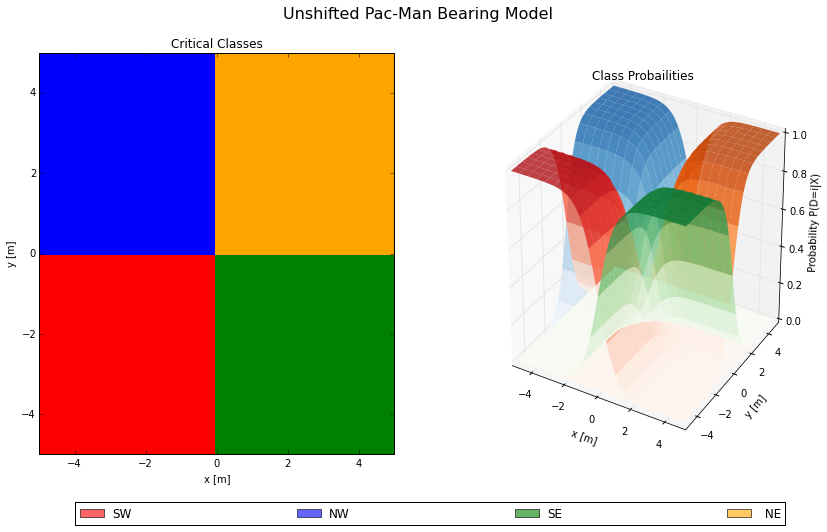

In [21]:
# See source at: https://github.com/COHRINT/cops_and_robots/blob/master/src/cops_and_robots/robo_tools/fusion/softmax.py
import numpy as np
from cops_and_robots.robo_tools.fusion.softmax import SoftMax
%matplotlib inline

labels = ['SW', 'NW', 'SE',' NE']
weights = np.array([[-1, -1],
                    [-1, 1],
                    [1, -1],
                    [1, 1],
                   ])
pacman = SoftMax(weights, class_labels=labels)
pacman.plot(title='Unshifted Pac-Man Bearing Model')

Which is along the right path, but needs to be shifted down to Pac-Man's location. Say Pac-Man is approximately one quarter of the map south from the center point, we can bias our model accordingly (assuming a $10m \times 10m$ space):

$$
\begin{align}
b_{SW} &= -2.5\\
b_{NW} &= 2.5\\
b_{SE} &= -2.5\\
b_{NE} &= 2.5\\
\end{align}
$$


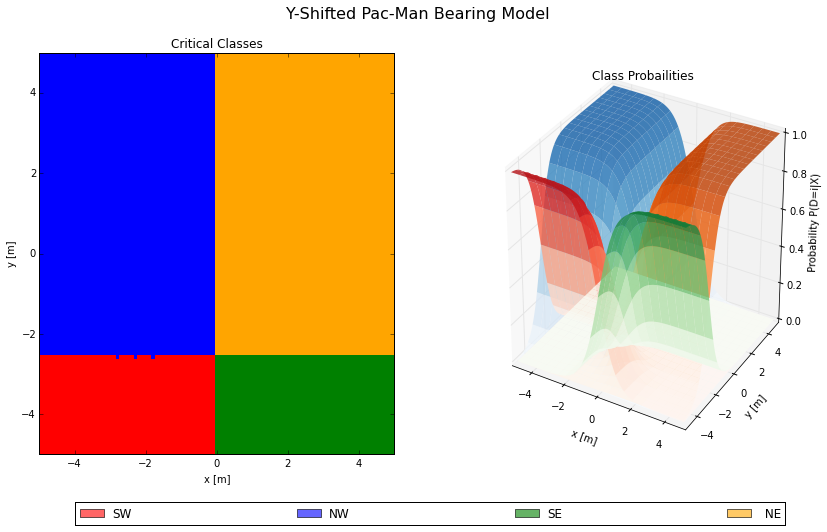

In [23]:
biases = np.array([-2.5, 2.5, -2.5, 2.5,])
pacman = SoftMax(weights, biases, class_labels=labels)
pacman.plot(title='Y-Shifted Pac-Man Bearing Model')

Looking good! Note that we'd get the same answer had we used the following weights:

$$
\begin{align}
b_{SW} &= -5\\
b_{NW} &= 0\\
b_{SE} &= -5\\
b_{NE} &= 0\\
\end{align}
$$
Because the class boundaries and probability distributions are defined by the *relative differences*.

But this simply shifts the weights in the $y$ direction. How do we go about shifting weights in any state dimension? 

Remember that our biases will essentially scale an entire class, so, what we did was scale up the two classes that have a positive scaling for negative $y$ values. If we want to place the center of the four classes in the top-left, for instance, we'll want to bias the NW class less than the other classes. 

Let's think of what happens if we use another coordinate system:

$$
\mathbf{x}' = \mathbf{x} + \mathbf{b}
$$

Where $\mathbf{x}'$ is our new state vector and $\mathbf{b}$ are offsets to each state in our original coordinate frame (assume the new coordinate system is unbiased). For example, something like:

$$
\mathbf{x}' = \begin{bmatrix}x & y\end{bmatrix}^T + \begin{bmatrix}2 & -3\end{bmatrix}^T = \begin{bmatrix}x + 2 & y -3\end{bmatrix}^T
$$ 

Can we represent this shift simply by adjusting our biases, instead of having to redefine our state vector? Assuming we're just shifting the distributions, the probabilities, and thus, the hyperplanes, will simply be shifted as well, so we have:

$$
0 = (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{x}' = (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{x} + (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{b}
$$

Which retains our original state and shifts only our biases. If we distribute the offset $\mathbf{b}$, we can define each class's bias term:

$$
\begin{align}
b_i - b_j &=  (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{b} \\
&= \mathbf{w}_i^T \mathbf{b} - \mathbf{w}_j^T \mathbf{b}
\end{align}
$$

Our bias for each class $i$ in our original coordinate frame is simply $\mathbf{w}_i^T \mathbf{b}$.

Let's try this out with $\mathbf{b} = \begin{bmatrix}2 & -3\end{bmatrix}^T$ (remembering that this will push the shifted origin negatively along the x-axis and positively along the y-axis):

$$
\begin{align}
b_{SW} &= \begin{bmatrix}-1 & -1 \end{bmatrix} \begin{bmatrix}2 \\ -3\end{bmatrix} = 1\\
b_{NW} &= \begin{bmatrix}-1 & 1 \end{bmatrix} \begin{bmatrix}2 \\ -3\end{bmatrix} =-5 \\
b_{SE} &= \begin{bmatrix}1 & -1 \end{bmatrix} \begin{bmatrix}2 \\ -3\end{bmatrix} = 5\\
b_{NE} &= \begin{bmatrix}1 & 1 \end{bmatrix} \begin{bmatrix}2 \\ -3\end{bmatrix} = -1 \\
\end{align}
$$

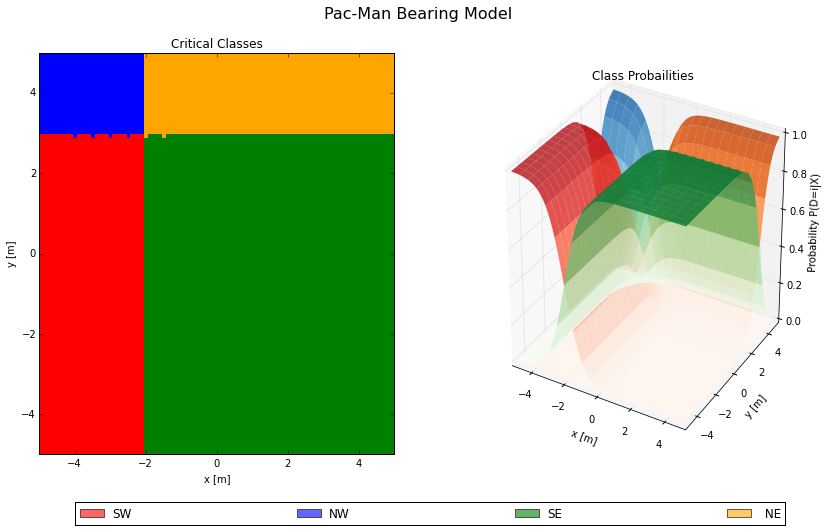

In [5]:
biases = np.array([1, -5, 5, -1,])
pacman = SoftMax(weights, biases, class_labels=labels)
pacman.plot(title='Shifted Pac-Man Bearing Model')

One other thing we can illustrate with this example: how would the SoftMax model change if we multiplied all our weights and biases by 10? 
We get:

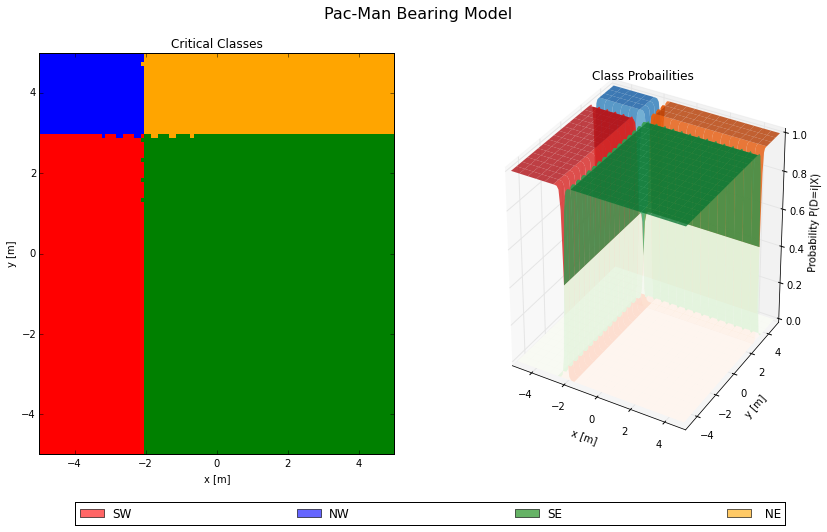

In [7]:
weights = np.array([[-10, -10],
                    [-10, 10],
                    [10, -10],
                    [10, 10],
                   ])
biases = np.array([10, -50, 50, -10,])
pacman = SoftMax(weights, biases, class_labels=labels)
pacman.plot(title='Steep Pac-Man Bearing Model')

Why does this increase in slope happen? Let's investigate.

## SoftMax slope for linear states

The [gradient](http://en.wikipedia.org/wiki/Gradient) of $P(L=i \vert \mathbf{x})$ will give us a function for the slope of our SoftMax model of class $i$. For a linear state space, such as our go-to $\mathbf{x} = \begin{bmatrix}x & y\end{bmatrix}$, our gradient is defined as:

$$
\nabla P(L=i \vert \mathbf{x}) = \nabla \frac{e^{\mathbf{w}_i^T \mathbf{x} + b_i}}{\sum_{k=1}^M e^{\mathbf{w}_k^T\mathbf{x} + b_k}} = 
\frac{\partial}{\partial x} \frac{e^{\mathbf{w}_i^T \mathbf{x}}}{\sum_{k=1}^M e^{\mathbf{w}_k^T\mathbf{x}}} \mathbf{\hat{i}} +
\frac{\partial}{\partial y} \frac{e^{\mathbf{w}_i^T \mathbf{x}}}{\sum_{k=1}^M e^{\mathbf{w}_k^T\mathbf{x}}} \mathbf{\hat{j}}
$$

Where $\mathbf{\hat{i}}$ and $\mathbf{\hat{j}}$ are unit vectors in the $x$ and $y$ dimensions, respectively. Given the structure of our equation, the form of either partial derivative will be the same as the other, so let's look at the partial with respect to $x$, using some abused notation:

\begin{align}
\frac{\partial P(L = i \vert \mathbf{x})} {\partial x} &= \frac{d P(L = i \vert x)} {dx} = 
\frac{\partial}{\partial x} \frac{e^{w_{i,x}x}}{\sum_{k=1}^M e^{w_{k,x}x}} \\
&= \frac{w_{i,x}e^{w_{i,x}x}\sum_{k=1}^M e^{w_{k,x}x} - e^{w_{i,x}x}(\sum_{k=1}^M w_{k,x}e^{w_{k,x}x})}{(\sum_{k=1}^M e^{w_{k,x}x})^2} \\
&= \frac{w_{i,x}e^{w_{i,x}x}\sum_{k=1}^M e^{w_{k,x}x}}{(\sum_{k=1}^M e^{w_{k,x}x})^2} - 
\frac{e^{w_{i,x}x}(\sum_{k=1}^M w_{k,x}e^{w_{k,x}x})}{(\sum_{k=1}^M e^{w_{k,x}x})^2}\\
&= w_{i,x} \left( \frac{e^{w_{i,x}x}}{\sum_{k=1}^M e^{w_{k,x}x}}\right) - 
\left( \frac{e^{w_{i,x}x}}{\sum_{k=1}^M e^{w_{k,x}x}}\right)\frac{\sum_{k=1}^M w_{k,x}e^{w_{k,x}x}}{\sum_{k=1}^M e^{w_{k,x}x}}\\
& = P(L = i \vert x) \left(w_{i,x} - \frac{\sum_{k=1}^M w_{k,x}e^{w_{k,x}x}}{\sum_{k=1}^M e^{w_{k,x}x}}\right) \\ 
& = P(L = i \vert x) \left(w_{i,x} - \sum_{k=1}^M w_{k,x}P(L = k \vert x) \right) \\ 
\end{align}

Where line 2 was found using the quotient rule. This is still hard to interpret, so let's break it down into multiple cases:

If $P(L = i \vert x) \approx 1$, the remaining probabilities are near zero, thus reducing the impact of their weights, leaving:

$$
\frac{\partial P(L = i \vert \mathbf{x})} {\partial x}
\approx P(L = i \vert x) \left(w_{i,x} - w_{i,x}P(L = i \vert x) \right)
= 0
$$

This makes sense: a dominating probability will be flat.

If $P(L = i \vert x) \approx 0$, we get:

$$
\frac{\partial P(L = i \vert \mathbf{x})} {\partial x}
\approx 0 \left(w_{i,x} - w_{i,x}P(L = i \vert x) \right)
= 0
$$

This also makes sense: a diminished probability will be flat.

We can expect the greatest slope of a [logistic function](http://en.wikipedia.org/wiki/Logistic_function) (which is simply a univariate SoftMax function) to appear at its midpoint  $P(L = i \vert x) = 0.5$. Our maximum slope, then, is:

$$
\frac{\partial P(L = i \vert \mathbf{x})} {\partial x}
= 0.5 \left(w_{i,x} - \sum_{k=1}^M w_{k,x}P(L = k \vert x) \right) \\ 
= 0.5 \left(w_{i,x} - \sum^M _{\substack{k = 1, \\ k \neq i}} w_{k,x}P(L = k \vert x) - 0.5w_{i,x}\right) \\
= 0.25w_{i,x} - 0.5\sum^M _{\substack{k = 1, \\ k \neq i}} w_{k,x}P(L = k \vert x) \\
$$


In general, we have the following ordinary differential equation:

$$
\frac{\partial P(L = i \vert \mathbf{x})} {\partial \mathbf{x}} = 
P(L = i \vert \mathbf{x}) \left(\mathbf{w}_{i} - \sum_{k=1}^M \mathbf{w}_{k}P(L = k \vert \mathbf{x}) \right) \\ 
$$

NOTE: This section feels really rough, and possibly unnecessary. I need to work on it some more.


## Rotations

Just as we were able to shift our SoftMax distributions to a new coordinate origin, we can apply a [rotation](http://en.wikipedia.org/wiki/Rotation_matrix) to our weights and biases. Let's once again update our weights and biases through a new, rotated, coordinate scheme:

$$
R(\theta)\mathbf{x}' = R(\theta)(\mathbf{x} + \mathbf{b})
$$

As before, we examine the case at the linear hyperplane boundaries:

$$
0 = (\mathbf{w}_i - \mathbf{w}_j)^T \mathbf{x}' = (\mathbf{w}_i - \mathbf{w}_j)^T R(\theta)\mathbf{x} + (\mathbf{w}_i - \mathbf{w}_j)^T R(\theta) \mathbf{b}
$$

Our weights are already defined, so we simply need to multiply them by $R(\theta)$ to find our rotated weights. Let's find our biases:

$$
\begin{align}
b_i - b_j &=  (\mathbf{w}_i - \mathbf{w}_j)^T R(\theta) \mathbf{b} \\
&= \mathbf{w}_i^T R(\theta) \mathbf{b} - \mathbf{w}_j^T R(\theta) \mathbf{b}
\end{align}
$$

So, under rotation, $b_i = \mathbf{w}_i^T R(\theta) \mathbf{b}$.

Let's try this with a two-dimensional rotation matrix using $\theta = \frac{\pi}{4} rad$ and $\mathbf{b} = \begin{bmatrix}2 & -3\end{bmatrix}^T$:

$$
\begin{align}
b_{SW} &= \begin{bmatrix}-1 & -1 \end{bmatrix}
\begin{bmatrix}\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}\\ \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\end{bmatrix} 
\begin{bmatrix}2 \\ -3\end{bmatrix} = -2\sqrt{2} \\
b_{NW} &= \begin{bmatrix}-1 & 1 \end{bmatrix}
\begin{bmatrix}\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}\\ \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\end{bmatrix} 
\begin{bmatrix}2 \\ -3\end{bmatrix} = -3\sqrt{2} \\
b_{SE} &= \begin{bmatrix}1 & -1 \end{bmatrix}
\begin{bmatrix}\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}\\ \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\end{bmatrix} 
\begin{bmatrix}2 \\ -3\end{bmatrix} = 3\sqrt{2} \\
b_{NE} &= \begin{bmatrix}1 & 1 \end{bmatrix}\begin{bmatrix}\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}\\ \frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}\end{bmatrix} 
 \begin{bmatrix}2 \\ -3\end{bmatrix} = 2\sqrt{2} \\
\end{align}
$$


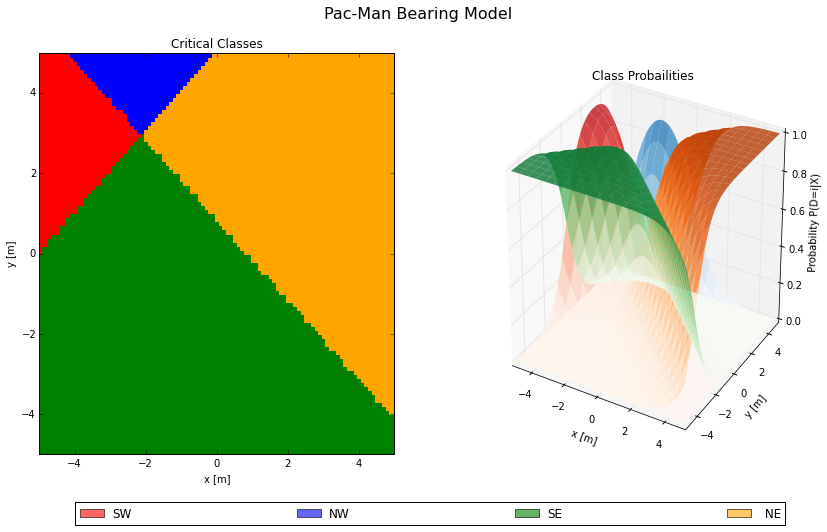

In [20]:
# Define rotation matrix
theta = np.pi/4
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])

# Rotate weights
weights = np.array([[-1, -1],
                    [-1, 1],
                    [1, -1],
                    [1, 1],
                   ])
weights = np.dot(weights,R)

# Apply rotated biases
biases = np.array([-2 * np.sqrt(2),
                   -3 * np.sqrt(2),
                   3 * np.sqrt(2),
                   2 * np.sqrt(2),])

pacman = SoftMax(weights, biases, class_labels=labels)
pacman.plot(title='Rotated and Shifted Pac-Man Bearing Model')

##Summary

That should be a basic introduction to the SoftMax model. We've only barely scraped the surface of why you might want to use SoftMax models as a tool for aspects of HRI. 

Let's move on to [Chapter 2](02_from_normals.ipynb) where we examine a more practical way of constructing SoftMax distributions.

In [5]:
from IPython.core.display import HTML

# Borrowed style from Probabilistic Programming and Bayesian Methods for Hackers
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
